<a href="https://colab.research.google.com/github/aetev/Learning-stuff-/blob/main/YF%20RL%20(2)%20(1)%20(19)%20test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tf_agents[reverb]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 624.4/624.4 kB 10.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 53.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 60.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.8/489.8 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 45.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 51.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 33.3

In [2]:
!pip install yfinance

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [4]:
import yfinance as yf
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.lib.stride_tricks import sliding_window_view
import tracemalloc

import tensorflow_probability as tfp

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Concatenate, GaussianNoise
from tensorflow.keras.regularizers import l2

from tf_agents.networks import network
from tf_agents.agents.categorical_dqn import categorical_dqn_agent
from tf_agents.environments import py_environment, tf_py_environment, utils
from tf_agents.specs import array_spec, tensor_spec
from tf_agents.trajectories import trajectory, time_step as ts
from tf_agents.replay_buffers.tf_uniform_replay_buffer import TFUniformReplayBuffer
from tf_agents.policies.random_tf_policy import RandomTFPolicy
from tf_agents.policies.boltzmann_policy import BoltzmannPolicy
from tf_agents.policies import tf_policy
from tf_agents.utils import common

In [5]:
BATCH_SIZE = 64 # @param {type:"integer"}
EVAL_EPISODES = 3 # @param {type:"integer"}
NUMBER_EPISODES = 10000000000 # @param {type:"integer"}
COLLECTION_STEPS = 1 # @param {type:"integer"}
EVAL_INTERVAL =  500 # @param {type:"integer"}

### <font color='purple'><center>**-------------------Create Data-------------------**</font>

In [6]:
end_date = datetime.now()
start_date = end_date - timedelta(days=729)

tickers = [
    'EURUSD=X', 'USDEUR=X',  # Euro/US Dollar
    'USDJPY=X', 'JPYUSD=X',  # US Dollar/Japanese Yen
    'GBPUSD=X', 'USDGBP=X',  # British Pound/US Dollar
    'USDCHF=X', 'CHFUSD=X',  # US Dollar/Swiss Franc
    'AUDUSD=X', 'USDAUD=X',  # Australian Dollar/US Dollar
    'USDCAD=X', 'CADUSD=X',  # US Dollar/Canadian Dollar
    'NZDUSD=X', 'USDNZD=X',  # New Zealand Dollar/US Dollar
]

data_list = []
for ticker in tickers:
    data = yf.download(ticker, start=start_date, end=end_date, interval='1h')
    data_list.append(data)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [7]:
def create_data(raw_data, window_size):
    High = raw_data['High'].to_numpy()
    Close = raw_data['Close'].to_numpy()
    Low = raw_data['Low'].to_numpy()
    Std = np.std(np.diff(Close))
    Close_Diff = np.diff(Close)/Std
    High_Adj = (High[1:]-Close[1:])/Std
    Low_Adj = (Close[1:]-Low[1:])/Std

    stack = np.stack((Close_Diff, High_Adj, Low_Adj), axis=1)

    window_view = np.lib.stride_tricks.sliding_window_view(stack, (window_size,),axis=0)

    Forex_Data = window_view[:-1]
    Forex_Data = Forex_Data.astype('float32')
    target = Close_Diff[window_size:]

    return Forex_Data, target


In [8]:
window_list = []
target_list = []
for data in data_list:
    window, target =  create_data(data, 50)
    window_list.append(window)
    target_list.append(target)


### <font color='red'><center>**-------------------Create Environment-------------------**</font>

In [9]:
def custom_formatter(x):
  return f'{x:.4f}'

def test_environment(env, num_steps):
    # Reset the environment
    observation = env.reset()

    # Get the upper bound of the action range
    action_spec = env.action_spec().maximum

    # Loop through the time steps and take random actions
    for _ in range(num_steps):
        # Select a random action from the range of valid values
        action = np.random.randint(0, action_spec)

        # Execute the action and get the next observation, reward, done, and info
        observation, reward, done, info = env.step(action)

        # Print the current time step
        np.set_printoptions(formatter={'float_kind':custom_formatter})
        print(action,"{:.4f}".format(reward),info[1])

In [10]:
def SortinoRatio(df, T):
    """Calculates the Sortino ratio from univariate excess returns.

    Args:
        df ([float]): The dataframe or pandas series of univariate excess returns.
        T ([integer]): The targeted return.
    """

    # Check if there are less than two numbers in the array or no downside returns
    if len(df) < 2:
        return -1
    if np.all(df >= T):
        return 0

    #downside deviation:
    temp = np.minimum(0, df - T)**2
    temp_expectation = np.mean(temp)
    downside_dev = np.sqrt(temp_expectation)

    #Sortino ratio:
    sortino_ratio = np.mean(df - T) / downside_dev

    return(sortino_ratio)

In [57]:
# Define the parameters
max_reward_per_step = .1
discount_factor = 0.95
num_steps = 100

# Calculate the maximum Q-value per step
max_q_value_per_step = max_reward_per_step * (1 - discount_factor**num_steps) / (1 - discount_factor)

print(max_q_value_per_step)

1.9881589415593304


In [161]:
start = 1
epi_length = 100
class TradingEnv(py_environment.PyEnvironment):

  def __init__(self):
    global start
    self._action_spec = array_spec.BoundedArraySpec(
        shape=(), dtype=np.int64, minimum=0, maximum=3, name='action')

    self._observation_spec = (
        array_spec.BoundedArraySpec(shape=(3,50), dtype=np.float32, name='observation1'),
        array_spec.BoundedArraySpec(shape=(2,), dtype=np.float32, name='observation2')
    )

    self._count = np.random.randint(1,10000)#startstart
    self._ticker = np.random.randint(0,len(window_list))

    self._max_ep_len = self._count + epi_length
    self._scaler = np.sum(np.absolute(target_list[self._ticker][self._count:self._max_ep_len]))
    self._state = (window_list[self._ticker][self._count-1], np.array([0, 0], dtype=np.float32))
    self._episode_ended = False
    self._trade_info = {'value': 0,'direction': 0}
    self._balance = np.array([])
    self._abssum = 0
    self._new = False


  def action_spec(self):
    return self._action_spec

  def observation_spec(self):
    return self._observation_spec

  def get_balance(self):
    return self._balance

  def _reset(self):
    global start
    self._count = np.random.randint(1,10000)#start
    self._ticker = np.random.randint(0,len(window_list))
    self._max_ep_len = self._count + epi_length
    self._scaler = np.sum(np.absolute(target_list[self._ticker][self._count:self._max_ep_len]))
    self._state = (window_list[self._ticker][self._count-1], np.array([0, 0], dtype=np.float32))
    self._episode_ended = False
    self._trade_info = {'value': 0,'direction': 0}
    self._balance = np.array([])
    self._abssum = 0
    self._new = False


    return ts.restart(self._state)

  def _step(self, action):
    global start

    if self._episode_ended:
      return self.reset()

    profit = 0
    reward = 0
    fee = 0
    cur_target = target_list[self._ticker][self._count]
    self._abssum += np.abs(cur_target)

    if action == 0:
        profit = self._trade_info['value']
        fee = .01
        self._trade_info['value'] = cur_target
        self._trade_info['direction'] = 1
    elif action == 1:
        profit = self._trade_info['value']
        fee = .01
        self._trade_info['value'] = -cur_target
        self._trade_info['direction'] = -1
    elif action == 2:
        self._trade_info['value'] += cur_target*self._trade_info['direction']
        if self._trade_info['value'] < -10:
          profit = self._trade_info['value']
          self._trade_info['value'] = 0
          self._trade_info['direction'] = 0
    else:
        profit = self._trade_info['value']
        self._trade_info['value'] = 0
        self._trade_info['direction'] = 0






    trade_array = np.array([self._trade_info['value'],self._trade_info['direction']], dtype=np.float32)


    self._state = (window_list[self._ticker][self._count], trade_array)

    if profit != 0:
        reward = profit/100

        self._balance = np.append(profit,self._balance)



    if self._abssum >= epi_length:
        if self._trade_info['value'] < 0:
            self._balance = np.append(profit,self._balance)
        self._episode_ended = True

    self._count += 1

    if self._episode_ended:
      reward = np.mean(self._balance)/100 if np.sum(self._balance) != 0 else 0
      return ts.termination(self._state, reward=0)
    else:
      return ts.transition(self._state, reward=reward, discount=.95)



env = TradingEnv()
utils.validate_py_environment(env, episodes=2)

print('Observation Spec:')
print(env.time_step_spec().observation)

print('Reward Spec:')
print(env.time_step_spec().reward)

print('Action Spec:')
print(env.action_spec())

train_env = tf_py_environment.TFPyEnvironment(env)
evaluation_env = tf_py_environment.TFPyEnvironment(env)

Observation Spec:
(BoundedArraySpec(shape=(3, 50), dtype=dtype('float32'), name='observation1', minimum=-3.4028234663852886e+38, maximum=3.4028234663852886e+38), BoundedArraySpec(shape=(2,), dtype=dtype('float32'), name='observation2', minimum=-3.4028234663852886e+38, maximum=3.4028234663852886e+38))
Reward Spec:
ArraySpec(shape=(), dtype=dtype('float32'), name='reward')
Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=3)


In [162]:
test_environment(env,100)

2 0.0000 [0.0000 0.0000]
1 0.0000 [-0.1696 -1.0000]
1 -0.0017 [0.7598 -1.0000]
1 0.0076 [0.6126 -1.0000]
1 0.0061 [-0.0875 -1.0000]
1 -0.0009 [-0.3967 -1.0000]
2 0.0000 [-1.5424 -1.0000]
0 -0.0154 [0.3867 1.0000]
0 0.0039 [1.0093 1.0000]
1 0.0101 [0.0177 -1.0000]
1 0.0002 [0.1175 -1.0000]
0 0.0012 [-1.3427 1.0000]
0 -0.0134 [-0.1581 1.0000]
0 -0.0016 [-0.4678 1.0000]
1 -0.0047 [-0.2163 -1.0000]
1 -0.0022 [-0.1170 -1.0000]
0 -0.0012 [-0.0117 1.0000]
0 -0.0001 [0.1989 1.0000]
1 0.0020 [0.4152 -1.0000]
1 0.0042 [-0.3451 -1.0000]
1 -0.0035 [0.3041 -1.0000]
1 0.0030 [-0.3041 -1.0000]
2 0.0000 [-0.6202 -1.0000]
2 0.0000 [-1.7108 -1.0000]
1 -0.0171 [0.1527 -1.0000]
1 0.0015 [0.3461 -1.0000]
1 0.0035 [-0.0528 -1.0000]
1 -0.0005 [0.8496 -1.0000]
2 0.0000 [0.9724 -1.0000]
2 0.0000 [0.8496 -1.0000]
2 0.0000 [1.1888 -1.0000]
1 0.0119 [-0.4798 -1.0000]
1 -0.0048 [0.1288 -1.0000]
2 0.0000 [-0.1581 -1.0000]
0 -0.0016 [0.9735 1.0000]
2 0.0000 [1.1497 1.0000]
1 0.0115 [-0.1293 -1.0000]
2 0.0000 [0.2466

### <font color='blue'><center>**-------------------Create Network-------------------**</font>

In [138]:
class CustomQNetwork(network.Network):
    def __init__(self, input_tensor_spec, action_spec, name='CustomQNetwork'):
        super(CustomQNetwork, self).__init__(input_tensor_spec=input_tensor_spec,
                                             state_spec=(),
                                             name=name)
        # Define your custom layers and architecture here
        self.LSTM1 = LSTM(units=200, activation='gelu', return_sequences=True)
        self.LSTM2 = LSTM(units=200, activation='gelu', return_sequences=False)
        self.BatchNorm1 = BatchNormalization()
        self.Concat = Concatenate()
        self.Dense1 = Dense(200,activation='gelu')
        self.BatchNorm2 = BatchNormalization()
        self.Dense2 = Dense(200,activation='gelu')
        self.BatchNorm3 = BatchNormalization()
        self.q_values_layer = Dense(action_spec.maximum - action_spec.minimum + 1,
                                                    activation=None)
        self.gaussian_noise_layer = GaussianNoise(stddev=.2)  # Add Gaussian noise with stddev=0.2

    def call(self, observation, step_type=None, network_state=(), training=False):
        # Split the observation into two arrays
        observation1, observation2 = observation

        if training:
            observation1 = self.gaussian_noise_layer(observation1)

        x = self.LSTM1(observation1)
        x = self.LSTM2(x)
        x = self.BatchNorm1(x)
        x = self.Concat([x,observation2])
        x = self.Dense1(x)
        x = self.BatchNorm2(x)
        x = self.Dense2(x)
        x = self.BatchNorm3(x)
        q_values = self.q_values_layer(x)
        return q_values, network_state

In [139]:
class CategoricalQNetwork(network.Network):
    def __init__(self, input_tensor_spec, action_spec, num_atoms=51, preprocessing_layers=None,
                 preprocessing_combiner=None, conv_layer_params=None, fc_layer_params=None,
                 activation_fn=tf.nn.relu, name='CategoricalQNetwork'):
        super(CategoricalQNetwork, self).__init__(input_tensor_spec=input_tensor_spec,
                                                  state_spec=(),
                                                  name=name)
        # Check if action_spec is a BoundedTensorSpec
        if not isinstance(action_spec, tensor_spec.BoundedTensorSpec):
            raise TypeError('action_spec must be a BoundedTensorSpec. Got: %s' % (action_spec,))

        self._num_actions = action_spec.maximum - action_spec.minimum + 1
        self._num_atoms = num_atoms

        # Create a BoundedTensorSpec for the q_network action
        q_network_action_spec = tensor_spec.BoundedTensorSpec((), tf.int32,
                                                              minimum=0,
                                                              maximum=self._num_actions * num_atoms - 1)

        # Create the q_network
        self._q_network = CustomQNetwork(input_tensor_spec=input_tensor_spec,
                                             action_spec=q_network_action_spec,
                                             )
    def call(self, observation, step_type=None, network_state=(), training=False):
        logits, network_state = self._q_network(observation, step_type, network_state, training=training)
        logits = tf.reshape(logits, [-1, self._num_actions, self._num_atoms])
        return logits, network_state
    @property
    def num_atoms(self):
        return self._num_atoms

In [140]:
observation_spec = train_env.observation_spec()
action_spec = train_env.action_spec()
num_atoms = 51
custom_network = CategoricalQNetwork(observation_spec,action_spec, num_atoms)

In [141]:
EPSILON_INIT = .5
EPSILON_MIN = 0.1
EPSILON_DECAY_STEPS = 2e5


# Define the epsilon decay function
def epsilon_decay(global_step):
    epsilon = EPSILON_INIT - (EPSILON_INIT - EPSILON_MIN) * tf.minimum(1.0, tf.cast(global_step, tf.float32) / EPSILON_DECAY_STEPS)
    return epsilon
train_env

In [142]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=0.001)
global_step = tf.Variable(0, name='global_step', trainable=False)
train_step_counter = tf.Variable(0)

C51_agent = categorical_dqn_agent.CategoricalDqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    categorical_q_network=custom_network,
    optimizer=optimizer,
    min_q_value=-1,
    max_q_value=2,
    epsilon_greedy=.2,
    n_step_update=2,
    boltzmann_temperature=None,
    target_update_period=100,
    td_errors_loss_fn=common.element_wise_squared_loss,
    gamma=1,
    train_step_counter=train_step_counter)
C51_agent.initialize()

### <font color='green'><center>**-------------------Create Replay Buffer And Training Loop-------------------**</font>

In [143]:
def timestamp_data(environment, policy, replay_buffer):
        time_step = environment.current_time_step()
        action_step = policy.action(time_step)
        next_time_step = environment.step(action_step.action)
        timestamp_trajectory = trajectory.from_transition(time_step, action_step, next_time_step)
        replay_buffer.add_batch(timestamp_trajectory)

In [144]:
#replay_buffer.clear()
#define replay buffer
replay_buffer = TFUniformReplayBuffer(
            data_spec=C51_agent.collect_data_spec,
            batch_size=train_env.batch_size,
            max_length=50000)

#random policy for filling buffer
random_policy = RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

train_env.reset()
#fill replay buffer
for _ in range(1000):
    timestamp_data(train_env, random_policy,replay_buffer)

#create dataset from buffer
dataset = replay_buffer.as_dataset(
            num_parallel_calls=tf.data.AUTOTUNE,
            sample_batch_size=BATCH_SIZE,
            num_steps=2).prefetch(tf.data.AUTOTUNE)

iterator = iter(dataset)


In [145]:
#define checkpointer
checkpoint_dir = '/tmp/MODEL2'

train_checkpointer = common.Checkpointer(
        ckpt_dir=checkpoint_dir,
        max_to_keep=1,
        agent=C51_agent,
        policy=C51_agent.policy,
        replay_buffer=replay_buffer,
        global_step=global_step
    )


In [146]:
#train_checkpointer.initialize_or_restore(checkpoint_dir)

0
2.4116774


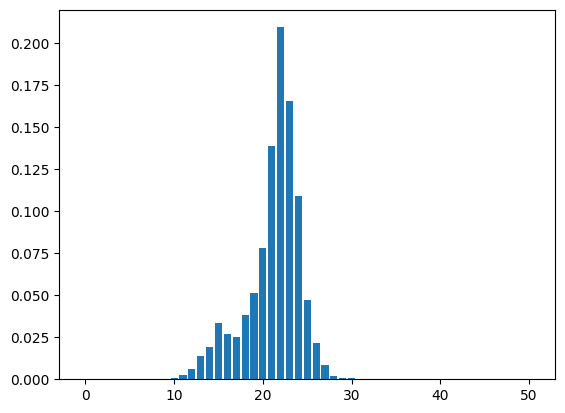

1
2.3867116


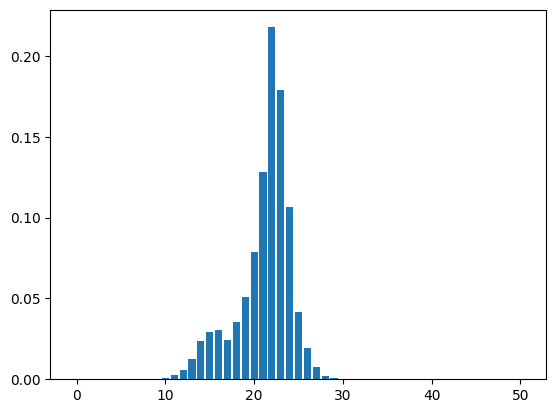

2
2.3695278


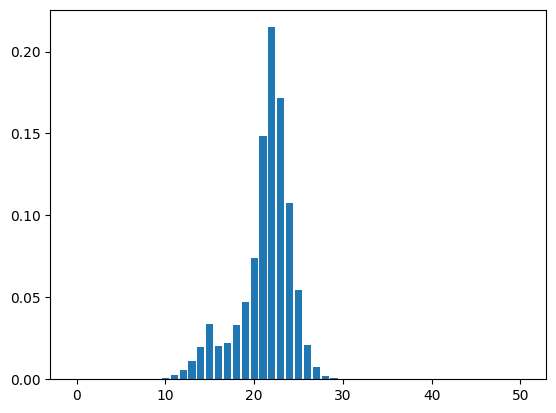

3
2.4206395


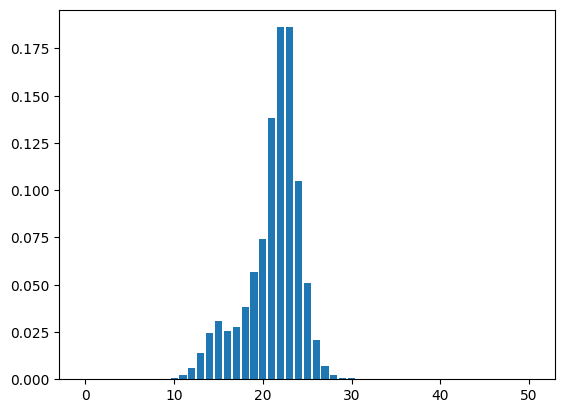

3
tf.Tensor(
[0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0001 0.0001 0.0001 0.0003
 0.0008 0.0025 0.0062 0.0141 0.0193 0.0335 0.0268 0.0248 0.0383 0.0513
 0.0778 0.1386 0.2093 0.1654 0.1088 0.0471 0.0218 0.0084 0.0022 0.0009
 0.0006 0.0004 0.0002 0.0001 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
 0.0000], shape=(51,), dtype=float32)


In [156]:
from scipy.stats import entropy
import scipy
# Get the distribution
time_step = train_env.current_time_step()
action_step = C51_agent.policy.action(time_step)
next_time_step = train_env.step(action_step.action)
state = time_step.observation
distributions = custom_network(state)[0][0]
testttt = tf.cast(distributions,tf.float32)
#softmax_distribution = tf.nn.softmax(testttt)
#entropy = -tf.reduce_sum(softmax_distribution * tf.math.log(softmax_distribution))

#the_val = testttt.numpy()
#val = scipy.stats.entropy(the_val)





def entropy_single(logits):
    #epsilon = 1e-10
    #min_value = tf.reduce_min(distribution)
    #tensor_subtracted = tf.subtract(distribution, min_value)
    #offset = tf.add(tensor_subtracted,epsilon)
    #sum_tensor = tf.reduce_sum(offset)
    #p = tf.divide(offset, sum_tensor)
    p = tf.nn.softmax(logits)
    return -tf.reduce_sum(p * tf.math.log(p))


def Entropy(Distribution):
    entropy_values = tf.map_fn(entropy_single, Distribution)
    highest_index = tf.math.argmax(entropy_values)
    return highest_index

for i in range(4):
    print(i)
    print(entropy_single(testttt[i]).numpy())
    dist = tf.nn.softmax(testttt[i])
    plt.bar(range(len(dist)), dist)
    #chart goes from low q to high q value
    plt.show()
print(Entropy(distributions).numpy())
#print(val)
print(tf.nn.softmax(testttt[0]))




In [148]:
from tf_agents.trajectories import policy_step
class CustomPolicy(tf_policy.TFPolicy):
    def __init__(self, time_step_spec, action_spec,network,agent, name=None):
        super(CustomPolicy, self).__init__(
            time_step_spec,
            action_spec,
            policy_state_spec=(),
            clip=False,
            name=name)
        self._network = network
        self._agent = agent
        self._epsilon = epsilon_decay(global_step)

    def _action(self, time_step, policy_state=(), seed=None):
        # Define your action logic here


        if tf.random.uniform([], minval=0, maxval=1, dtype=tf.float32) < self._epsilon:
            Distribution = self._network(time_step.observation)[0][0]
            tensors = []

            highest_index = Entropy(Distribution)
            action = tf.cast(highest_index,tf.int64)
            action = tf.reshape(action,(1,))
        else:
            action = self._agent.policy.action(time_step)[0]
        return policy_step.PolicyStep(action, state=policy_state, info=())

    def _get_initial_state(self, batch_size=None):
        # Define your initial state logic here
        return ()

In [149]:
time_step_spec = train_env.time_step_spec()
action_spec = train_env.action_spec()
print(action_spec)

BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(3))


In [150]:
my_policy = CustomPolicy(time_step_spec,action_spec,custom_network,C51_agent)

In [151]:
time_step = train_env.current_time_step()
action_step = my_policy.action(time_step)

print(action_step)

PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int64, numpy=array([3])>, state=(), info=())


In [152]:
def run_environment(env,policy):
    time_step = env.reset()
    reward = 0.0
    while not time_step.is_last():
        action = policy.action(time_step)
        next_time_step = env.step(action)
        reward += next_time_step.reward[0]
        time_step = next_time_step

    return reward

In [163]:




@tf.function
def train(agent):


    for step in tf.range(1000):
        for _ in tf.range(COLLECTION_STEPS):
        #while not time_step.is_last():
            timestamp_data(train_env, agent.collect_policy, replay_buffer)

        experience, info = next(iterator)
        train_loss = agent.train(experience).loss

        if step % EVAL_INTERVAL == 0:
            avg_reward = run_environment(evaluation_env,agent.policy)

            tf.print('Reward:',avg_reward,' Loss:',train_loss,' Epsilon:',epsilon_decay(global_step))


        #Increment the global step variable
        global_step.assign_add(1)


print("**********************************")
print("Training C51_agent")
print("**********************************")
for i in range(1000000000):
    C51_reward = train(C51_agent)
    #train_checkpointer.save(global_step)

**********************************
Training C51_agent
**********************************


KeyboardInterrupt: ignored

In [159]:
def compute_avg_return_print(environment, policy, num_episodes=10):

  total_return = 0.0
  for episode in range(num_episodes):
    balance_arr = []
    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      obs = time_step.observation

      balance = np.sum(env.get_balance())
      balance_arr.append(balance)
      # Print the episode number and observation at each step
      print(f"Episode {episode + 1}: Observation = {obs[1]}")

      episode_return += time_step.reward
    plt.plot(balance_arr)
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

Episode 1: Observation = [[0.0000 0.0000]]
Episode 1: Observation = [[0.2626 1.0000]]
Episode 1: Observation = [[-0.1525 1.0000]]
Episode 1: Observation = [[0.0000 0.0000]]
Episode 1: Observation = [[-0.1694 1.0000]]
Episode 1: Observation = [[-0.4913 1.0000]]
Episode 1: Observation = [[0.3134 1.0000]]
Episode 1: Observation = [[0.0000 0.0000]]
Episode 1: Observation = [[0.0000 0.0000]]
Episode 1: Observation = [[0.0000 0.0000]]
Episode 1: Observation = [[0.0000 0.0000]]
Episode 1: Observation = [[-0.6437 -1.0000]]
Episode 1: Observation = [[-0.5082 1.0000]]
Episode 1: Observation = [[-1.5076 1.0000]]
Episode 1: Observation = [[-0.4489 1.0000]]
Episode 1: Observation = [[-0.7962 1.0000]]
Episode 1: Observation = [[-0.5506 1.0000]]
Episode 1: Observation = [[-3.4302 1.0000]]
Episode 1: Observation = [[-4.5821 1.0000]]
Episode 1: Observation = [[-4.6499 1.0000]]
Episode 1: Observation = [[-3.3201 1.0000]]
Episode 1: Observation = [[-3.4980 1.0000]]
Episode 1: Observation = [[0.0000 0.000

KeyboardInterrupt: ignored

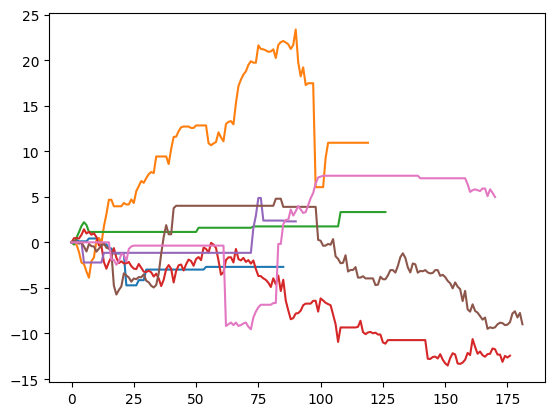

In [164]:
avg_return = compute_avg_return_print(evaluation_env, C51_agent.policy, 20)
print(avg_return)

In [ ]:
snapshot = tracemalloc.take_snapshot()
top_stats = snapshot.statistics('lineno')

for stat in top_stats[:10]:
    print(stat)